## 1. Import Library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## 2. Import Data

In [4]:
df = pd.read_csv("triangle_dataset.csv")

1. Buka ini https://www.kaggle.com/datasets/dharinesh/triangle-types-dataset/data
2. Download
3. Import ke file coding lu

## 3. Buat Kolom ttg Sudut (Menggunakan Hukum Cosinus)

In [7]:
#Definisikan nilai sisi ke dlm suatu variabel
a = df['Side_A'].values
b = df['Side_B'].values
c = df['Side_C'].values

In [8]:
#Hitung cosinus sudut (pakai np.clip untuk mencegah domain error)
cos_C = np.clip((a**2 + b**2 - c**2) / (2*a*b), -1.0, 1.0)
cos_B = np.clip((a**2 + c**2 - b**2) / (2*c*a), -1.0, 1.0)
cos_A = np.clip((c**2 + b**2 - a**2) / (2*c*b), -1.0, 1.0)

In [9]:
# Hitung sudut dalam radian
angle_A_rad = np.arccos(cos_A)
angle_B_rad = np.arccos(cos_B)
angle_C_rad = np.arccos(cos_C)

#Konversi ke derajat
angle_A_deg = np.degrees(angle_A_rad)
angle_B_deg = np.degrees(angle_B_rad)
angle_C_deg = np.degrees(angle_C_rad)

### Buat Klasifikasi untuk Menglompokkan Segitiga Berdasarkan Sudutnnya (tbh, I hate this)

In [11]:
def classify_angle_type(row):
    #Definisikan sisi (yes, lagi) untuk klasifikasi segitiga sama sisi
    s_a, s_b, s_c = row['Side_A'], row['Side_B'], row['Side_C']

    #Definisikan sudut
    ang_a, ang_b, ang_c = row['temp_angle_A'], row['temp_angle_B'] , row['temp_angle_C']
    
    #Set nilai toleransi(biar ga error)
    tolerance = 1e-3

    #Buat klasifikasi untuk segitiga sama sisi
    if np.isclose(s_a, s_b) and np.isclose(s_b, s_c):
        return "Equiangular"
        
    #Buat klasifikasi untuk segitiga siku-siku. rada nguli sih, but you get the point     
    elif np.isclose(ang_a, 90, atol=tolerance) or \
        np.isclose(ang_b, 90, atol=tolerance) or \
        np.isclose(ang_c, 90, atol=tolerance):
        return "Right"

    #Buat klasifikasi untuk segitiga tumpul
    elif ang_a > 90 or ang_b > 90 or ang_c > 90:
        return "Obtuse"
    
    #Buat klasifikasi untuk segitiga lancip
    else:
        return "Acute"

In [12]:
#Tambahkan sudut sementara ke dalam df untuk diakses fungsi apply
df['temp_angle_A'] = angle_A_deg
df['temp_angle_B'] = angle_B_deg
df['temp_angle_C'] = angle_C_deg

In [13]:
#Terapkan fungsi ke setiap baris untuk membuat kolom baru
df['angle_type'] = df.apply(classify_angle_type, axis=1)

In [14]:
#Hapus kolom sudut sementara jika tidak diperlukan lagi
df = df.drop(columns=['temp_angle_A','temp_angle_B','temp_angle_C'])

In [15]:
#Cek hasil dan distribusi kelas sudut baru
print(df['angle_type'].value_counts())
print(df['Triangle_Type'].value_counts())
print(df.head())

angle_type
Acute          10823
Equiangular    10051
Obtuse          9118
Right              8
Name: count, dtype: int64
Triangle_Type
Equilateral    10000
Isosceles      10000
Scalene        10000
Name: count, dtype: int64
   Side_A  Side_B  Side_C Triangle_Type   angle_type
0    98.0    98.0    98.0   Equilateral  Equiangular
1    41.0    41.0    41.0   Equilateral  Equiangular
2    76.0    76.0    76.0   Equilateral  Equiangular
3     2.0     2.0     2.0   Equilateral  Equiangular
4    35.0    35.0    35.0   Equilateral  Equiangular


### Hapus segitiga right angle
Seperti yang kita lihat sebelumnya, segitiga right angle memiliki proporsi yang sangat sedikit, dibandingkan jenis segitiga lainnya. Sehingga, mau ga mau harus kita hapus

In [17]:
rows_before_filter = len(df)
# Buat DataFrame baru yang TIDAK mengandung 'Right' di kolom 'angle_type'
df_filtered = df[df['angle_type'] != 'Right'].copy()
rows_after_filter = len(df_filtered)
print(f"Jumlah baris sebelum filter: {rows_before_filter}")
print(f"Jumlah baris setelah filter: {rows_after_filter}")
print(f"Jumlah baris 'Right' yang dihapus: {rows_before_filter - rows_after_filter}")

Jumlah baris sebelum filter: 30000
Jumlah baris setelah filter: 29992
Jumlah baris 'Right' yang dihapus: 8


In [18]:
# Tampilkan distribusi setelah filter
print("\nDistribusi tipe sudut SETELAH filter 'Right':")
print(df_filtered['angle_type'].value_counts())


Distribusi tipe sudut SETELAH filter 'Right':
angle_type
Acute          10823
Equiangular    10051
Obtuse          9118
Name: count, dtype: int64


## 4. Split Data (75/15/15)

Jadi, sebelum melakukan training, preprocessing, atau apapun itu, data harus dibagi terlebih dahulu. Karena untuk mencegah terjadinya kebocoran data ke algoritma training

In [21]:
from sklearn.model_selection import train_test_split

#Pilih fitur (Ini pekerjaan paling obvious yagesya)
features = df_filtered[['Side_A', 'Side_B', 'Side_C']]

#Di sini, kita siapkan tergetnya dulu. Target adalah kedua tipe (kita akan handle sebagai dictionary atau tuple nanti saat melatih)
target_side = df_filtered['Triangle_Type']
target_angle = df_filtered['angle_type']

Setelah itu, kita akan melakukan split pada data. Dalam kasus ini, aku akan split data menjadi 3 bagian [Train (70%), Validation (15%). dan Test (15%)]. Pembagian data akan dilakukan dalam tahap berikut:

1. Data (100%) --> Train (70%) dan Temp(30%)
2. Temp (30%) --> Validation (15%) dan Test(15%)

In [23]:
#Pembagian tahap awal
X_train, X_temp, y_train_side, y_temp_side, y_train_angle, y_temp_angle = train_test_split(features, target_side, target_angle, test_size=0.30, random_state=133, stratify=target_side)

In [24]:
#Split Kedua
X_val, X_test, y_val_side, y_test_side, y_val_angle, y_test_angle = train_test_split(X_temp, y_temp_side, y_temp_angle, test_size=0.50, random_state=42, stratify=y_temp_side)

In [25]:
#Cek ukuran hasil split
print("Ukuran X_train:", X_train.shape)
print("Ukuran X_val:", X_val.shape)
print("Ukuran X_test:", X_test.shape)
print("\nUkuran y_train_side:", y_train_side.shape)
print("Ukuran y_val_side:", y_val_side.shape)
print("Ukuran y_test_side:", y_test_side.shape)
print("\nUkuran y_train_angle:", y_train_angle.shape)
print("Ukuran y_val_angle:", y_val_angle.shape)
print("Ukuran y_test_angle:", y_test_angle.shape)

Ukuran X_train: (20994, 3)
Ukuran X_val: (4499, 3)
Ukuran X_test: (4499, 3)

Ukuran y_train_side: (20994,)
Ukuran y_val_side: (4499,)
Ukuran y_test_side: (4499,)

Ukuran y_train_angle: (20994,)
Ukuran y_val_angle: (4499,)
Ukuran y_test_angle: (4499,)


## 4. Scaling

Di sini, aku akan gunakan standard scaler

In [28]:
from sklearn.preprocessing import StandardScaler

#Definisikan oknum scaler
scaler = StandardScaler()

#Lakukan "scaling" hanya pada data training
scaler.fit(X_train)

#Terapin semua scaling kepada tiga set yang sudah dibagi: train, validation, dan test
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [29]:
#Cek hasil scaling
print("Data Training Sebelum Scaling (contoh):\n", X_train.head())
print("\nData Training Setelah Scaling (contoh):\n", X_train_scaled[:5])

Data Training Sebelum Scaling (contoh):
        Side_A  Side_B  Side_C
23373   72.70   99.00   62.00
4661    63.00   63.00   63.00
19013    6.00    6.00   29.00
3479    86.67   86.67   86.67
28209   61.61   95.00   66.00

Data Training Setelah Scaling (contoh):
 [[ 0.72309367  1.65705196  0.32105349]
 [ 0.36979538  0.3552618   0.3573161 ]
 [-1.70628738 -1.70590595 -0.8756127 ]
 [ 1.23191606  1.21118883  1.21565213]
 [ 0.3191681   1.51240861  0.46610394]]


Udah bener yagesya. Sekarang lanjut ke metode encoding

## 5. One-Hot Encoding

In [32]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

#Buat oknum encodingnya
encoder_side = OneHotEncoder(sparse_output=False)

### Encoding untuk target 'triangle_type' (Sisi)

In [34]:
#Fit encoder HANYA pada data training target sisi (y_train_side)
#Encoder perlu ditata ulang karena encoder cuma nerima input 2D
y_train_side_reshaped = np.array(y_train_side).reshape(-1, 1)
y_val_side_reshaped = np.array(y_val_side).reshape(-1, 1)
y_test_side_reshaped = np.array(y_test_side).reshape(-1, 1)

encoder_side.fit(y_train_side_reshaped)

OneHotEncoder(sparse_output=False)

In [35]:
#Terapkan encoding ke semua set target sisi
y_train_side_encoded = encoder_side.transform(y_train_side_reshaped)
y_val_side_encoded = encoder_side.transform(y_val_side_reshaped)
y_test_side_encoded = encoder_side.transform(y_test_side_reshaped)

### Encoding untuk target 'angle_type' (Sudut)

In [37]:
#Buat objek OneHotEncoder baru
encoder_angle = OneHotEncoder(sparse_output=False)

In [38]:
#Fit encoder HANYA pada data training target sudut (y_train_angle)
y_train_angle_reshaped = np.array(y_train_angle).reshape(-1, 1)
y_val_angle_reshaped = np.array(y_val_angle).reshape(-1, 1)
y_test_angle_reshaped = np.array(y_test_angle).reshape(-1, 1)

encoder_angle.fit(y_train_angle_reshaped)

OneHotEncoder(sparse_output=False)

In [39]:
#Terapkan encoding ke semua set target sudut
y_train_angle_encoded = encoder_angle.transform(y_train_angle_reshaped)
y_val_angle_encoded = encoder_angle.transform(y_val_angle_reshaped)
y_test_angle_encoded = encoder_angle.transform(y_test_angle_reshaped)

In [40]:
#Cek hasil encoding
print("\nContoh y_train_side asli:", y_train_side[:5].values)
print("Contoh y_train_side encoded:\n", y_train_side_encoded[:5])

print("\nContoh y_train_angle asli:", y_train_angle[:5].values)
print("Contoh y_train_angle encoded:\n", y_train_angle_encoded[:5])


Contoh y_train_side asli: ['Scalene' 'Equilateral' 'Isosceles' 'Equilateral' 'Scalene']
Contoh y_train_side encoded:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

Contoh y_train_angle asli: ['Obtuse' 'Equiangular' 'Obtuse' 'Equiangular' 'Obtuse']
Contoh y_train_angle encoded:
 [[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


## 6. Deep Learning (Tiati Stress,gw jg hampir gila, ngerjain ini)

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import pickle # Untuk simpan/load history

### Konfigurasi Eksperimen *(UBAH PARAMETER DI BAGIAN INI YGY)*

In [44]:
# --- Parameter Utama Eksperimen ---
EXPERIMENT_PARAMS = {
    'optimizer': 'rmsprop',         # Ganti sesuai kebutuhan: 'adam', 'sgd', 'rmsprop'
    'num_hidden_layers': 3,     # Ganti sesuai kebutuhan: 0, 1, 2, ...
    'neurons_per_layer': 32,    # Ganti sesuai kebutuhan: 8, 16, 32, ...
    'hidden_activation': 'relu',# Ganti sesuai kebutuhan: 'relu', 'sigmoid', 'tanh'
    'output_heads': 'both'      # Ganti sesuai kebutuhan: 'both', 'sides', 'angles'
}

# --- Pengaturan Training ---
EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 10
try:
    INPUT_SHAPE = (X_train_scaled.shape[1],) # Tentukan input shape di sini
except NameError:
    print("Error: Pastikan variabel X_train_scaled sudah terdefinisi dari pre-processing!")
    exit()

In [45]:
# --- Penamaan File Output ---
config_str = "_".join([f"{k}-{v}" for k, v in EXPERIMENT_PARAMS.items()])
config_str += "_baseline" # Tandai sebagai baseline
MODEL_FILENAME = f"best_model_{config_str}.keras"
HISTORY_FILENAME = f"history_{config_str}.pkl"

print(f"--- Memulai Eksperimen Baseline: {config_str} ---")
print(f"Model akan disimpan sebagai: {MODEL_FILENAME}")

# FUNGSI MODEL
def build_flexible_mlp(input_shape, params):
    """Jadi, kita bakal masukin parameter MLP yang sudah di-set ke model MLP-nya"""
    num_hidden_layers = params['num_hidden_layers']
    neurons_per_layer = params['neurons_per_layer']
    hidden_activation = params['hidden_activation']
    optimizer_name = params['optimizer']
    output_heads = params['output_heads']

    #Definisikan layer input, ya 3 sisi tadi
    inputs = Input(shape=input_shape, name='input_layer')
    x = inputs
    if num_hidden_layers > 0:
        x = Dense(units=neurons_per_layer, activation=hidden_activation, name='hidden_layer_1')(inputs)
        for i in range(1, num_hidden_layers):
            x = Dense(units=neurons_per_layer, activation=hidden_activation, name=f'hidden_layer_{i+1}')(x)

    # Definisikan layer output, yaitu si sisi dan sudutnya
    output_side = Dense(units=3, activation='softmax', name='output_side')(x)
    output_angle = Dense(units=3, activation='softmax', name='output_angle')(x)

    #Di sini, aku mau masukin kondisi untuk fungsi yang ingin kita buat. ada 'both', 'sides', dan 'angles'. Pake fungsi 'if' aja, biar simpel
    if output_heads == 'both':
        outputs = [output_side, output_angle]
        loss = {'output_side': 'categorical_crossentropy', 'output_angle': 'categorical_crossentropy'}
        metrics = {'output_side': 'accuracy', 'output_angle': 'accuracy'}
    elif output_heads == 'sides':
        outputs = output_side; loss = 'categorical_crossentropy'; metrics = ['accuracy']
    elif output_heads == 'angles':
        outputs = output_angle; loss = 'categorical_crossentropy'; metrics = ['accuracy']
    else: raise ValueError("output_heads tidak valid")

    #Ini cuman part kompilasi aja
    model = Model(inputs=inputs, outputs=outputs, name='flexible_triangle_mlp')
    model.compile(optimizer=optimizer_name, loss=loss, metrics=metrics)
    print(f"Model dikompilasi dengan optimizer: {optimizer_name}")
    model.summary()
    return model

--- Memulai Eksperimen Baseline: optimizer-rmsprop_num_hidden_layers-3_neurons_per_layer-32_hidden_activation-relu_output_heads-both_baseline ---
Model akan disimpan sebagai: best_model_optimizer-rmsprop_num_hidden_layers-3_neurons_per_layer-32_hidden_activation-relu_output_heads-both_baseline.keras


In [46]:
# PERSIAPAN TRAINING
print("\n--- Mempersiapkan Training (Baseline) ---")
# --- Callbacks ---
# Callbacks adalah sebuah sistem untuk menghentikan proses training bila loss yang didapatkan, sudah tidak bisa lebih kecil lagi
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=MODEL_FILENAME, save_weights_only=False,
                                   monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# Panggil fungsi yang sudah didefinisikan di kode sebelumnya
model = build_flexible_mlp(input_shape=INPUT_SHAPE, params=EXPERIMENT_PARAMS)

# Masukin semua data yang sudah di-scaling dan di-one-hot-encoding
output_heads = EXPERIMENT_PARAMS['output_heads']
if output_heads == 'both':
    y_train_target = {'output_side': y_train_side_encoded, 'output_angle': y_train_angle_encoded}
    y_val_target = {'output_side': y_val_side_encoded, 'output_angle': y_val_angle_encoded}
elif output_heads == 'sides':
    y_train_target = y_train_side_encoded
    y_val_target = y_val_side_encoded
elif output_heads == 'angles':
    y_train_target = y_train_angle_encoded
    y_val_target = y_val_angle_encoded

# TRAINING MODEL
print(f"\n--- Memulai Training Model Baseline: {config_str} ---")
start_time = time.time()
history = None
try:
    history = model.fit(
        x=X_train_scaled,
        y=y_train_target,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_scaled, y_val_target),
        callbacks=callbacks_list,
        sample_weight=None,
        shuffle=True,
        verbose=1
    )
    training_time = time.time() - start_time
    print(f"Pelatihan selesai dalam {training_time:.2f} detik.")

#Ini adalah fungsi penangkal error. kalo gaada, juga gapapa. tp klo ada, akan jauh lebih nyaman
except Exception as e:
    training_time = time.time() - start_time
    print(f"\n***** ERROR SAAT TRAINING ({training_time:.2f} detik) *****: {e}")
    history = None


--- Mempersiapkan Training (Baseline) ---
Model dikompilasi dengan optimizer: rmsprop


Model: "flexible_triangle_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 3)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ hidden_layer_1 (Dense)        │ (None, 32)                │             128 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ hidden_layer_2 (Dense)        │ (None, 32)                │           1,056 │ hidden_layer_1[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ hidden_layer_3 (Dense)        │ (None, 32)                │           1,056 │ hidden_layer_2[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_side (Dense)           │ (None, 3)                 │              99 │ hidden_layer_3[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_angle (Dense)          │ (None, 3)                 │              99 │ hidden_layer_3[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,438 (9.52 KB)

 Trainable params: 2,438 (9.52 KB)

 Non-trainable params: 0 (0.00 B)


--- Memulai Training Model Baseline: optimizer-rmsprop_num_hidden_layers-3_neurons_per_layer-32_hidden_activation-relu_output_heads-both_baseline ---
Epoch 1/50
650/657 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6314 - output_angle_accuracy: 0.6442 - output_angle_loss: 0.7922 - output_side_accuracy: 0.6103 - output_side_loss: 0.8392
Epoch 1: val_loss improved from inf to 0.79072, saving model to best_model_optimizer-rmsprop_num_hidden_layers-3_neurons_per_layer-32_hidden_activation-relu_output_heads-both_baseline.keras
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.6265 - output_angle_accuracy: 0.6457 - output_angle_loss: 0.7895 - output_side_accuracy: 0.6112 - output_side_loss: 0.8369 - val_loss: 0.7907 - val_output_angle_accuracy: 0.8535 - val_output_angle_loss: 0.3368 - val_output_side_accuracy: 0.7546 - val_output_side_loss: 0.4542
Epoch 2/50
648/657 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6936 - output_angle_accuracy: 0.8877 - output_angle_loss: 0.2876 - output_side_accura

## 7. Evaluasi Model Deep Learning (Bagian ini lebih kematian lagi 💀💀💀)


--- Mengevaluasi Model (Tanpa 'Right'): optimizer-rmsprop_num_hidden_layers-3_neurons_per_layer-32_hidden_activation-relu_output_heads-both_baseline ---
Memuat model terbaik dari: best_model_optimizer-rmsprop_num_hidden_layers-3_neurons_per_layer-32_hidden_activation-relu_output_heads-both_baseline.keras
Membuat prediksi dengan model.predict()...
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Analisis Detail: Output SISI ---
Classification Report (Sisi):
              precision    recall  f1-score   support

 Equilateral       0.98      1.00      0.99      1500
   Isosceles       0.96      0.98      0.97      1500
     Scalene       1.00      0.95      0.98      1499

    accuracy                           0.98      4499
   macro avg       0.98      0.98      0.98      4499
weighted avg       0.98      0.98      0.98      4499

Confusion Matrix (Sisi):


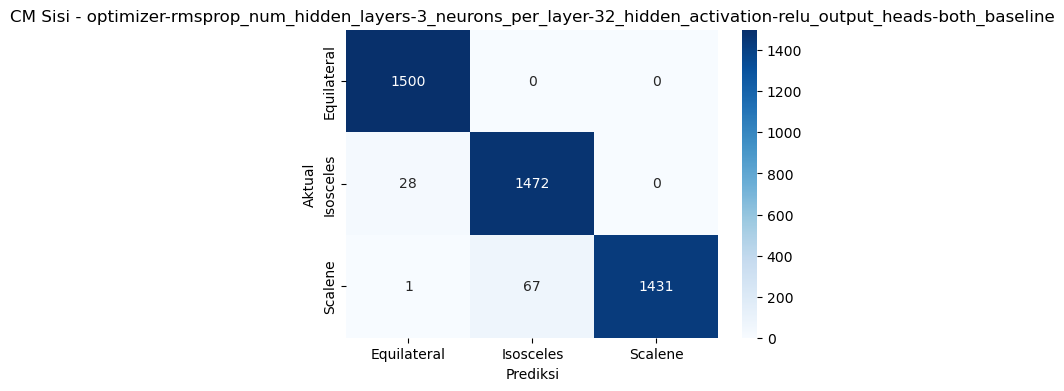


--- Analisis Detail: Output SUDUT (Tanpa 'Right') ---
Classification Report (Sudut):
              precision    recall  f1-score   support

       Acute       0.99      0.97      0.98      1603
 Equiangular       0.99      1.00      0.99      1512
      Obtuse       0.98      0.99      0.99      1384

    accuracy                           0.99      4499
   macro avg       0.99      0.99      0.99      4499
weighted avg       0.99      0.99      0.99      4499

Confusion Matrix (Sudut):


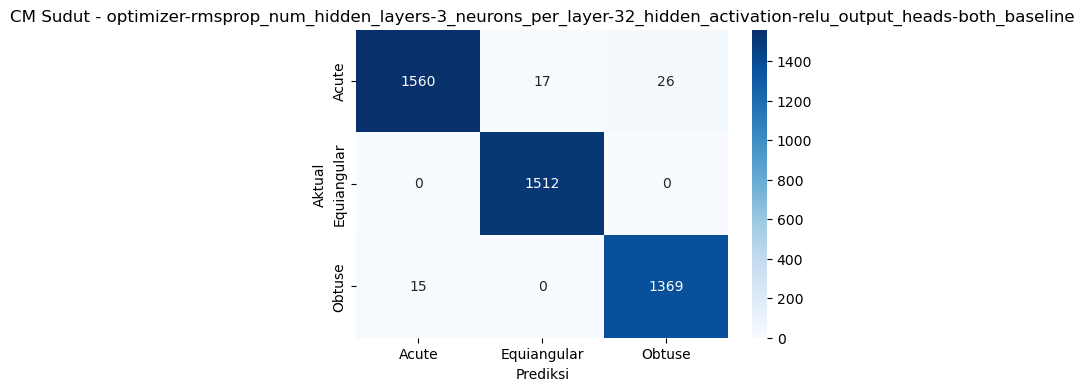


--- Evaluasi Selesai: optimizer-rmsprop_num_hidden_layers-3_neurons_per_layer-32_hidden_activation-relu_output_heads-both_baseline ---


In [48]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

print(f"\n--- Mengevaluasi Model (Tanpa 'Right'): {config_str} ---")
evaluation_summary = {} # Untuk menyimpan hasil .evaluate()

# 1. Cek dan Load Model
if not os.path.exists(MODEL_FILENAME):
    print(f"Error: File model terbaik {MODEL_FILENAME} tidak ditemukan.")
    # Mungkin keluar atau set evaluation_summary ke None
    evaluation_summary = None
else:
    print(f"Memuat model terbaik dari: {MODEL_FILENAME}")
    try:
        loaded_model = tf.keras.models.load_model(MODEL_FILENAME)

# 2. Siapkan Target Test untuk .evaluate()
        if output_heads == 'both':
            y_test_target_eval = {'output_side': y_test_side_encoded, 'output_angle': y_test_angle_encoded} # Sudut 3 kolom
        elif output_heads == 'sides':
            y_test_target_eval = y_test_side_encoded
        elif output_heads == 'angles':
            y_test_target_eval = y_test_angle_encoded # Sudut 3 kolom
        else: # Kasus tidak valid (seharusnya sudah ditangani sebelumnya)
             raise ValueError("output_heads tidak valid saat menyiapkan target evaluasi.")

# 3. Prediksi pada Test Set
        print("Membuat prediksi dengan model.predict()...")
        predictions = loaded_model.predict(X_test_scaled)

# 4. Proses Prediksi & Analisis Detail
        pred_labels_side, pred_labels_angle = None, None
        try:
            if output_heads == 'both':
                pred_labels_side = encoder_side.inverse_transform(predictions[0]).flatten()
                pred_labels_angle = encoder_angle.inverse_transform(predictions[1]).flatten() # Encoder 3 kelas
            elif output_heads == 'sides':
                pred_labels_side = encoder_side.inverse_transform(predictions).flatten()
            elif output_heads == 'angles':
                pred_labels_angle = encoder_angle.inverse_transform(predictions).flatten() # Encoder 3 kelas

            # --- Analisis Detail: Output SISI ---
            if y_test_side is not None and pred_labels_side is not None:
                print("\n--- Analisis Detail: Output SISI ---")
                side_labels = encoder_side.categories_[0] # Ambil label dari encoder
                print("Classification Report (Sisi):")
                print(classification_report(
                    y_test_side, pred_labels_side,
                    labels=side_labels, target_names=side_labels, zero_division=0
                ))
                print("Confusion Matrix (Sisi):")
                cm = confusion_matrix(y_test_side, pred_labels_side, labels=side_labels)
                cm_df = pd.DataFrame(cm, index=side_labels, columns=side_labels)
                plt.figure(figsize=(6,4)); sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues'); plt.title(f'CM Sisi - {config_str}'); plt.ylabel('Aktual'); plt.xlabel('Prediksi'); plt.show()

            # --- Analisis Detail: Output SUDUT ---
            if y_test_angle is not None and pred_labels_angle is not None:
                print("\n--- Analisis Detail: Output SUDUT (Tanpa 'Right') ---")
                angle_labels = encoder_angle.categories_[0] # Ambil label (3 kelas) dari encoder
                print("Classification Report (Sudut):")
                print(classification_report(
                    y_test_angle, pred_labels_angle,
                    labels=angle_labels, target_names=angle_labels, zero_division=0
                ))
                print("Confusion Matrix (Sudut):")
                cm = confusion_matrix(y_test_angle, pred_labels_angle, labels=angle_labels)
                cm_df = pd.DataFrame(cm, index=angle_labels, columns=angle_labels)
                # Ukuran plot bisa disesuaikan krn hanya 3x3
                plt.figure(figsize=(6,4)); sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues'); plt.title(f'CM Sudut - {config_str}'); plt.ylabel('Aktual'); plt.xlabel('Prediksi'); plt.show()

        except Exception as e_inv:
            print(f"Error saat inverse_transform atau plotting: {e_inv}")

    except Exception as e_load:
        print(f"Gagal memuat atau mengevaluasi model. Error: {e_load}")
        evaluation_summary = None # Tandai evaluasi gagal

print(f"\n--- Evaluasi Selesai: {config_str} ---")